In [387]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',100)

In [388]:
df_orig = pd.read_csv("labeled_data.csv")
df = df_orig

In [389]:
df_orig

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;"
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy"
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [390]:
df = pd.DataFrame(df)

In [391]:
'''
class label for majority of CF users: 

0 - hate speech 
1 - offensive language 
2 - neither

'''

'\nclass label for majority of CF users: \n\n0 - hate speech \n1 - offensive language \n2 - neither\n\n'

In [392]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;"
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy"
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [393]:
#Function to clean the tweets 
def preprocessing(df,column):
    
    lemmatizer = WordNetLemmatizer()
    
    #Gets rid of @username(s)
    df[column] = df[column].apply(lambda x: re.sub(r'@[^ ]* ', '', x))
    
    #Gets rid of anything that is a number of non-alpha character
    df[column] = df[column].apply(lambda x: (re.sub(r'[^a-zA-Z ]', '', x)))
    
    #Gets rid of "RT" if it pops up in a tweet 
    df[column] = df[column].apply(lambda x: re.sub(r'RT', '', x))
    
    #Gets rid of "http" and the following link
    df[column] = df[column].apply(lambda x:re.sub(r'http[^\s]*', '', x))

    #lowercases everything in the tweet 
    df[column] = df[column].apply(lambda x: x.lower())
    
    #Break up into word tokens 
    df["tokens"] = df["tweet"].apply(nltk.word_tokenize)
    
    #remove stopwords
    sw = stopwords.words("english")
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in sw])
    
    #Lemmatizing words 
    for array in df["tokens"]:
        for word in array:
            word = lemmatizer.lemmatize(word)
    
    #Putting lemmatized and cleaned words array back into a sentence 
    tweetModified = []
    for array in df["tokens"]:
        sentence = ""
        
        for word in array:
            if array.index(word) == len(array)-1:
                sentence = sentence + word
            else:
                sentence = sentence + word + " "
                
        tweetModified.append(sentence)
        
    df["tweetModified"] = pd.DataFrame(tweetModified)
    return df

In [394]:
df = preprocessing(df,"tweet")

In [395]:
df_final = df.drop(["Unnamed: 0","count","hate_speech","offensive_language","neither"], axis = 1)

In [396]:
df_final

,class,tweet,tokens,tweetModified
0,2,as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out,"[woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]",woman shouldnt complain cleaning house amp man always take trash
1,1,boy dats coldtyga dwn bad for cuffin dat hoe in the st place,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, hoe, st, place]",boy dats coldtyga dwn bad cuffin dat hoe st place
2,1,dawg you ever fuck a bitch and she start to cry you be confused as shit,"[dawg, ever, fuck, bitch, start, cry, confused, shit]",dawg ever fuck bitch start cry confused shit
3,1,she look like a tranny,"[look, like, tranny]",look like tranny
4,1,the shit you hear about me might be true or it might be faker than the bitch who told it to ya,"[shit, hear, might, true, might, faker, bitch, told, ya]",shit hear might true might faker bitch told ya
...,...,...,...,...
24778,1,yous a muthafin lie right his tl is trash now mine bible scriptures and hymns,"[yous, muthafin, lie, right, tl, trash, mine, bible, scriptures, hymns]",yous muthafin lie right tl trash mine bible scriptures hymns
24779,2,youve gone and broke the wrong heart baby and drove me redneck crazy,"[youve, gone, broke, wrong, heart, baby, drove, redneck, crazy]",youve gone broke wrong heart baby drove redneck crazy
24780,1,young buck wanna eat dat nigguh like i aint fuckin dis up again,"[young, buck, wan, na, eat, dat, nigguh, like, aint, fuckin, dis]",young buck wan na eat dat nigguh like aint fuckin dis
24781,1,youu got wild bitches tellin you lies,"[youu, got, wild, bitches, tellin, lies]",youu got wild bitches tellin lies


In [397]:
def plot_confusion_matrix(cm, labels):
    # Create the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)

    # Add labels and title for clarity
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    
    # Show the plot
    plt.show()

In [398]:
vectorizer = CountVectorizer()

x = df_final["tweetModified"]
y = df_final["class"]

text_counts = vectorizer.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(text_counts,y,test_size = .20, train_size = .80, random_state = 42)

In [399]:
SVC_classifier = SVC()
SVC_classifier.fit(x_train,y_train)
y_pred = SVC_classifier.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.05      0.09       290
           1       0.92      0.96      0.94      3832
           2       0.81      0.91      0.86       835

    accuracy                           0.90      4957
   macro avg       0.75      0.64      0.63      4957
weighted avg       0.88      0.90      0.88      4957



In [400]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.05      0.09       290
           1       0.92      0.96      0.94      3832
           2       0.81      0.91      0.86       835

    accuracy                           0.90      4957
   macro avg       0.75      0.64      0.63      4957
weighted avg       0.88      0.90      0.88      4957



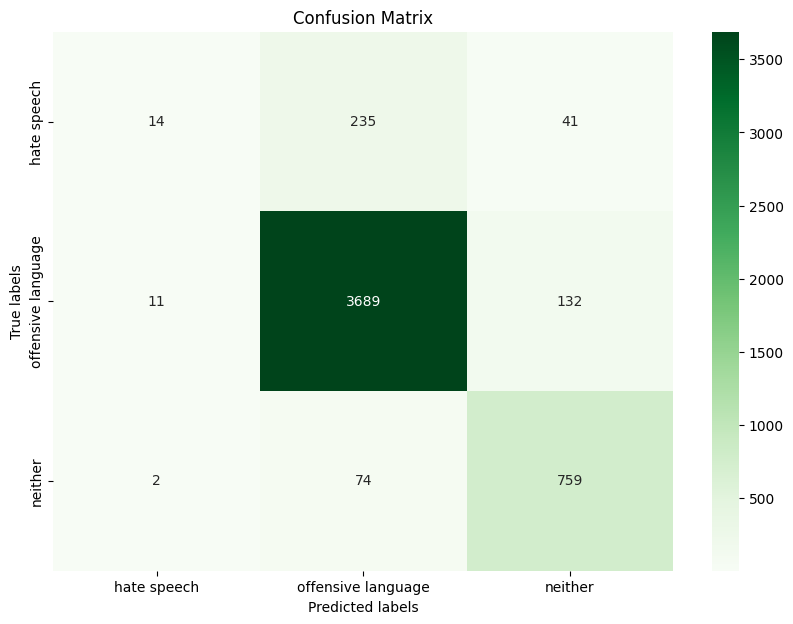

In [405]:
SVC_CM = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(SVC_CM,["hate speech","offensive language","neither"])